In [1]:
import scanpy as sc 
import numpy as np 
import pandas as pd 

/ihome/djishnu/alw399/.local/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [ ]:
adata_train = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/slideseq_mouse_lymphnode.h5ad')
adata_1der = sc.read_h5ad('/ix/djishnu/Yijia/project_asthma_lung/1_slide_tcr_seq/data/slideTCR_asthma_lymphnode_tangramAnno_wTCR_wRegion_w1DERCT_sample1_test.h5ad')

adata_1der.obs['cell_type'] = adata_train.obs.cell_type.astype(str).reindex(adata_1der.obs_names, axis=0).fillna('unknown')
adata_1der.var.index = adata_1der.var.index.str.capitalize()
sc.pp.normalize_total(adata_1der)
sc.pp.log1p(adata_1der)

slideseq = adata_1der[adata_1der.obs.cell_type.isin(['Tfh', 'Treg', 'Th2'])]
slideseq

In [3]:
slideseq.obs['transferred'] = np.where(slideseq.obs['1DER'], '1', '0')
slideseq.obs['transferred'].value_counts()

/tmp/ipykernel_102146/3837435115.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  slideseq.obs['transferred'] = np.where(slideseq.obs['1DER'], '1', '0')


transferred
0    3830
1     260
Name: count, dtype: int64

In [4]:
slideseq.var.index = slideseq.var.index.str.capitalize()

In [91]:
scrna = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/rctd_outputs/mouse_lymphnode_slideseq/zhongli_ref_202401203_mannually_woDoublet.h5ad')
scrna = scrna[scrna.obs.cell_type.isin(['Tfh', 'Treg', 'Th2'])]

In [96]:
visium = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
visium = visium[visium.obs.cell_type.isin(['Tfh', 'Treg', 'Th2'])]

In [97]:
shared_genes = set(scrna.var_names) & set(slideseq.var_names) & set(visium.var_names)
shared_genes = list(shared_genes)
len(shared_genes)

2062

In [98]:
scrna = scrna[:, shared_genes]
slideseq = slideseq[:, shared_genes]
visium = visium[:, shared_genes]

In [99]:
adt_counts = pd.read_csv('/ix/djishnu/shared/djishnu_kor11/rctd_outputs/mouse_lymphnode_slideseq/adt_counts.csv', index_col=0)
adt_counts.sort_values(by='adt_count', ascending=False)

,adt_count
cell_barcode,
TATACCTAGATGTTCC-1,161290
TCTTTGACAAGGGCAT-1,112799
AACGTCAAGTCAACAA-1,93685
ACCCTTGTCTTAGCCC-1,88288
AGCCAGCGTTCAGCTA-1,37891
...,...
GGCTTGGAGGTGTGAC-1,0
GGCTTGGAGTAAATGC-1,0
ACGGGTCTCATACGGT-1,0


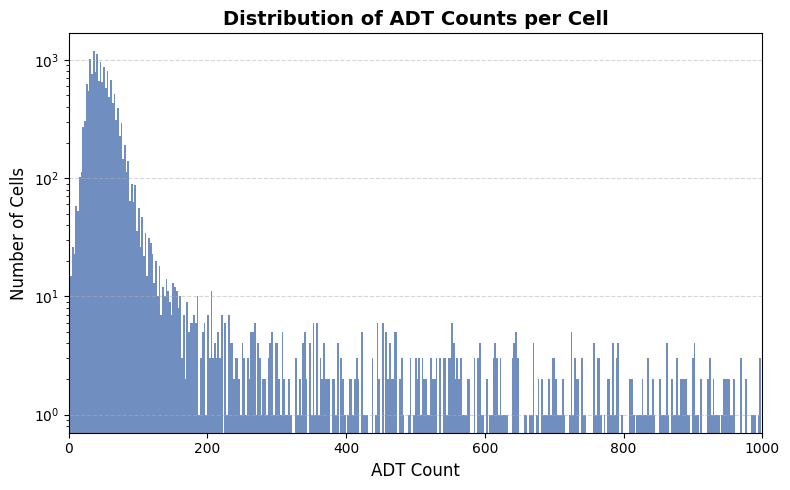

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(
    adt_counts[adt_counts.adt_count < 1000].adt_count, 
    bins=400, color="#4C72B0", alpha=0.8)
plt.yscale('log')
plt.xlabel('ADT Count', fontsize=12)
plt.ylabel('Number of Cells', fontsize=12)
plt.title('Distribution of ADT Counts per Cell', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlim(0, 1000)

plt.tight_layout()
plt.show()

In [101]:
transferred = adt_counts[adt_counts.adt_count > 150].index.values
len(transferred)

1309

In [102]:
unsure = adt_counts[(adt_counts.adt_count <= 150) & (adt_counts.adt_count > 0)]
len(unsure)

16215

In [13]:
scrna.obs['transferred'] = np.where(scrna.obs.index.isin(transferred), '1', '0')
scrna[scrna.obs.transferred == '1'].obs.cell_type.value_counts()

/tmp/ipykernel_102146/1295509964.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scrna.obs['transferred'] = np.where(scrna.obs.index.isin(transferred), '1', '0')


cell_type
Tfh     73
Th2     30
Treg     4
Name: count, dtype: int64

In [14]:
scrna.obs['transferred'].value_counts()

transferred
0    873
1    107
Name: count, dtype: int64

In [15]:
scrna = scrna[~scrna.obs.index.isin(unsure.index)]
scrna.obs['transferred'].value_counts()

transferred
0    556
1    107
Name: count, dtype: int64

In [16]:
107/556

0.19244604316546762

In [16]:
# scrna.write_h5ad('slide_runs/scRNA_transferred.h5ad')

In [17]:
value_counts = scrna[scrna.obs.transferred == '1'].obs.cell_type.value_counts().to_dict()
tfh = np.random.choice(scrna[(scrna.obs.transferred == '0') & (scrna.obs.cell_type == 'Tfh')].obs.index, size=value_counts['Tfh'], replace=False)
treg = np.random.choice(scrna[(scrna.obs.transferred == '0') & (scrna.obs.cell_type == 'Treg')].obs.index, size=value_counts['Treg'], replace=False)
th2 = np.random.choice(scrna[(scrna.obs.transferred == '0') & (scrna.obs.cell_type == 'Th2')].obs.index, size=value_counts['Th2'], replace=False)
scrna_transferred = sc.concat([scrna[np.r_[tfh, treg, th2]], scrna[scrna.obs.transferred == '1']])
scrna_transferred 

AnnData object with n_obs × n_vars = 214 × 2062
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'leiden_res_1.00', 'leiden_res_1.50', 'leiden_res_2.00', 'transferred'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [18]:
scrna_transferred.obs['transferred'].value_counts()

transferred
0    107
1    107
Name: count, dtype: int64

In [19]:
scrna_transferred.obs.cell_type.value_counts()

cell_type
Tfh     146
Th2      60
Treg      8
Name: count, dtype: int64

In [20]:
# scrna_transferred.write_h5ad('slide_runs/scRNA_transferred_matched.h5ad')

In [21]:
scrna = scrna_transferred

In [103]:
scrna = sc.read_h5ad('slide_runs_transfer/scRNA_transferred.h5ad')
scrna.obs.cell_type.value_counts()

cell_type
Tfh     300
Treg    223
Th2     140
Name: count, dtype: int64

In [104]:
scrna[scrna.obs.transferred == '1'].obs.cell_type.value_counts()

cell_type
Tfh     73
Th2     30
Treg     4
Name: count, dtype: int64

In [105]:
scrna.X.min(), scrna.X.max()

(0.0, 3.60847562225579)

In [112]:
scrna.obs['transferred'] = scrna.obs.transferred.astype(str).astype('category')

sc.tl.rank_genes_groups(
    scrna,
    groupby='transferred',
    groups=['1'],
    reference='0',
    method='wilcoxon',
    use_raw=False
)

scrna_degs = sc.get.rank_genes_groups_df(scrna, group='1')
scrna_degs

,names,scores,logfoldchanges,pvals,pvals_adj
0,Trbv2,8.194088,1.911893,2.524996e-16,5.206543e-13
1,Trac,5.789380,0.481322,7.064696e-09,7.283701e-06
2,Ptms,5.050274,0.932669,4.411756e-07,3.032347e-04
3,St8sia1,4.795639,1.159910,1.621572e-06,7.659710e-04
4,Il4,4.768356,1.759531,1.857350e-06,7.659710e-04
...,...,...,...,...,...
2057,Ltb,-4.104485,-0.624285,4.052169e-05,4.641985e-03
2058,Tpt1,-4.162356,-0.149754,3.149800e-05,4.059305e-03
2059,Izumo1r,-4.239519,-0.803830,2.239993e-05,3.299190e-03
2060,Cd6,-4.335145,-1.838421,1.456640e-05,2.932942e-03


In [113]:
scrna_degs[(scrna_degs['pvals_adj'] < 0.05) & (scrna_degs['logfoldchanges'].abs() > 0.0)].set_index('names')


,scores,logfoldchanges,pvals,pvals_adj
names,,,,
Trbv2,8.194088,1.911893,2.524996e-16,5.206543e-13
Trac,5.789380,0.481322,7.064696e-09,7.283701e-06
Ptms,5.050274,0.932669,4.411756e-07,3.032347e-04
St8sia1,4.795639,1.159910,1.621572e-06,7.659710e-04
Il4,4.768356,1.759531,1.857350e-06,7.659710e-04
Tcf7,4.701941,0.884559,2.576991e-06,8.856258e-04
Trbc1,4.522264,1.006125,6.118177e-06,1.567442e-03
Cd8b1,4.498564,1.177689,6.841405e-06,1.567442e-03
Stk39,4.308690,0.990966,1.642248e-05,2.932942e-03


In [114]:
# genes = ['Trbc1', 'Trbv2', 'Trac']
genes = scrna_degs[(scrna_degs['pvals_adj'] < 0.05) & (scrna_degs['logfoldchanges'] > 0.0)]['names']
gex_df = scrna[:, genes].to_df()
pos_score = gex_df.mean(axis=1)

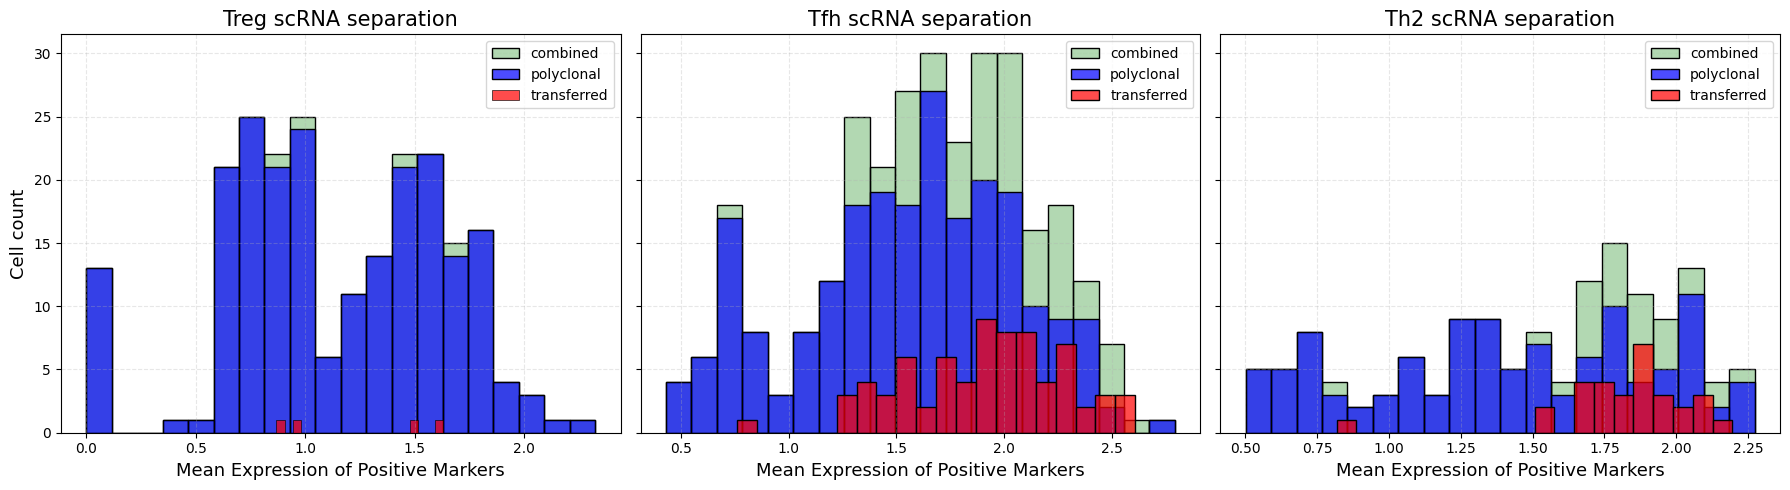

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns 

cell_types = ['Treg', 'Tfh', 'Th2']
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ct in enumerate(cell_types):
    ax = axes[i]
    idx = scrna.obs['cell_type'] == ct
    ct_pos_score = pos_score[idx]
    ct_transferred = scrna.obs.loc[idx, 'transferred']

    sns.histplot(
        ct_pos_score, color='green', alpha=0.3, edgecolor='k', label='combined', bins=20, stat='count', ax=ax
    )
    sns.histplot(
        ct_pos_score[ct_transferred == '0'], 
        color='blue', alpha=0.7, edgecolor='k', label='polyclonal', bins=20, stat='count', ax=ax
    )
    sns.histplot(
        ct_pos_score[ct_transferred == '1'], 
        color='red', alpha=0.7, edgecolor='k', label='transferred', bins=20, stat='count', ax=ax
    )

    ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
    ax.set_title(f"{ct} scRNA separation", fontsize=15)
    ax.grid(True, linestyle='--', alpha=0.3)
    if i == 0:
        ax.set_ylabel("Cell count", fontsize=13)
    else:
        ax.set_ylabel("")
    ax.legend()

plt.tight_layout()
plt.show()

In [126]:
import numpy as np

for cell_type in ['Treg', 'Tfh', 'Th2']:
    idx = scrna.obs['cell_type'] == cell_type
    ct_pos_score = pos_score[idx]
    ct_transferred = scrna.obs.loc[idx, 'transferred']

    best_percentile = 0.0
    best_prop = 0.0
    best_n_above = 0

    for percentile in np.linspace(0.01, 1, 100):
        cutoff = np.percentile(ct_pos_score, percentile * 100)
        above_cutoff = ct_pos_score > cutoff
        n_above = above_cutoff.sum()
        n_transferred_above = ((ct_transferred == '1') & above_cutoff).sum()
        prop = n_transferred_above / n_above if n_above > 0 else 0

        if prop > best_prop:
            best_prop = prop
            best_percentile = percentile
            best_n_above = n_above

    print(f"{cell_type} | Best percentile: {best_percentile}, Best proportion: {best_prop} ({best_n_above} cells)")

Treg | Best percentile: 0.7100000000000001, Best proportion: 0.03076923076923077 (65 cells)
Tfh | Best percentile: 0.97, Best proportion: 0.6666666666666666 (9 cells)
Th2 | Best percentile: 0.55, Best proportion: 0.3968253968253968 (63 cells)


In [127]:
scrna[scrna.obs.transferred == '1'].obs.cell_type.value_counts() / scrna.obs.cell_type.value_counts()

cell_type
Tfh     0.243333
Th2     0.214286
Treg    0.017937
Name: count, dtype: float64

In [128]:
percentile_dict = {
    'Treg': 0.71,
    'Tfh': 0.97,
    'Th2': 0.55
}

In [129]:
adata_train = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/slideseq_mouse_lymphnode.h5ad')
adata_1der = sc.read_h5ad('/ix/djishnu/Yijia/project_asthma_lung/1_slide_tcr_seq/data/slideTCR_asthma_lymphnode_tangramAnno_wTCR_wRegion_w1DERCT_sample1_test.h5ad')

adata_1der.obs['cell_type'] = adata_train.obs.cell_type.astype(str).reindex(adata_1der.obs_names, axis=0).fillna('unknown')
adata_1der.var.index = adata_1der.var.index.str.capitalize()
sc.pp.normalize_total(adata_1der)
sc.pp.log1p(adata_1der)

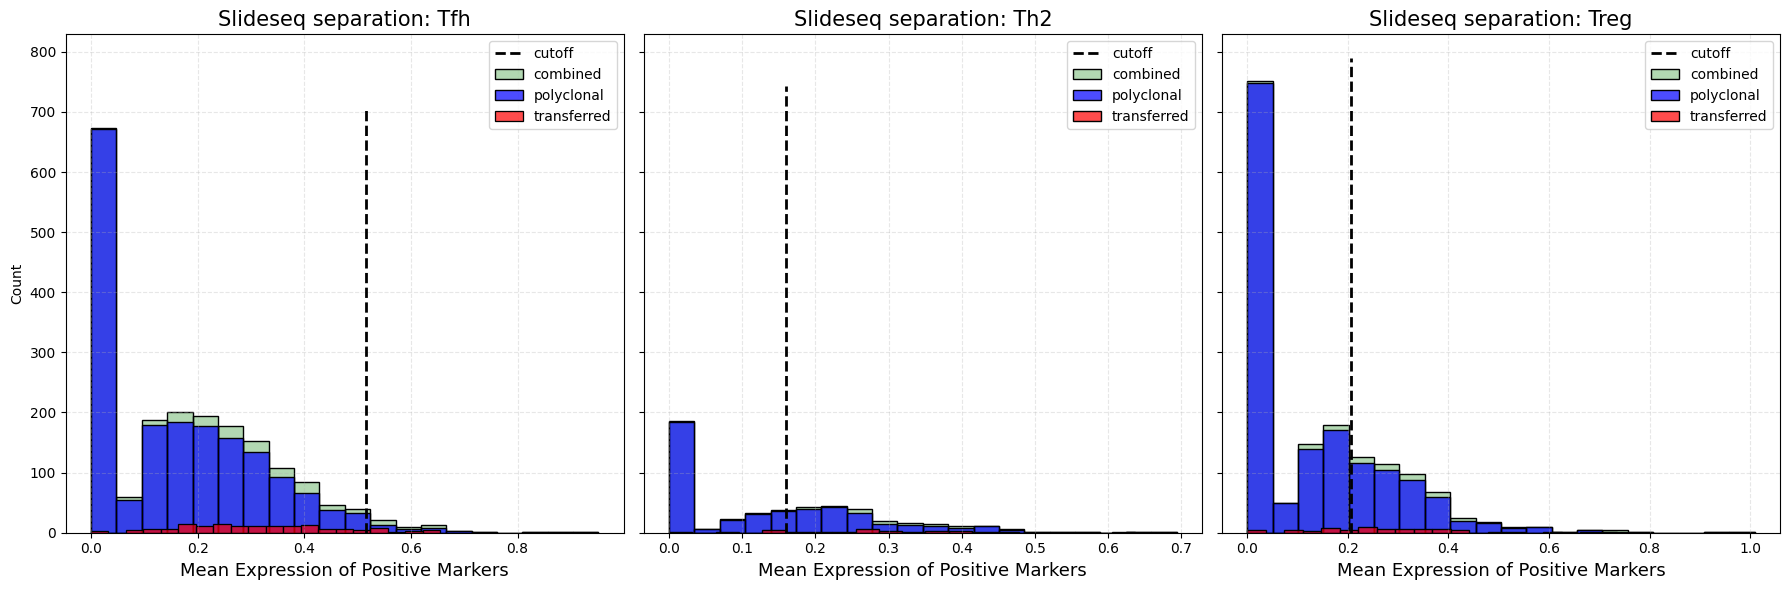

In [132]:
gex_df = adata_1der[:, genes].to_df()
pos_score = gex_df.mean(axis=1)
cell_types = ['Tfh', 'Th2', 'Treg']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, cell_type in enumerate(cell_types):
    ax = axes[i]
    idx = adata_1der.obs['cell_type'] == cell_type
    pos_score_ct = pos_score[idx]
    one_der = adata_1der.obs.loc[idx, '1DER']

    sns.histplot(
        pos_score_ct, color='green', alpha=0.3, edgecolor='k', label='combined', bins=20, stat='count', ax=ax
    )
    sns.histplot(
        pos_score_ct[one_der == False], 
        color='blue', alpha=0.7, edgecolor='k', label='polyclonal', bins=20, stat='count', ax=ax)
    sns.histplot(
        pos_score_ct[one_der == True], 
        color='red', alpha=0.7, edgecolor='k', label='transferred', bins=20, stat='count', ax=ax)

    cutoff = np.percentile(pos_score_ct, percentile_dict[cell_type] * 100)
    ax.vlines(cutoff, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='black', linestyle='--', linewidth=2, label='cutoff')

    ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
    ax.set_title(f"Slideseq separation: {cell_type}", fontsize=15)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()
    # ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [140]:
transferred = []

for cell_type in cell_types:
    idx = adata_1der.obs['cell_type'] == cell_type
    pos_score_ct = pos_score[idx]
    cutoff = np.percentile(pos_score_ct, percentile_dict[cell_type] * 100)
    transferred.extend(pos_score_ct[pos_score_ct > cutoff].index.values)

len(transferred), len(set(adata_1der[adata_1der.obs.index.isin(transferred)].obs_names) & set(adata_1der[adata_1der.obs['1DER']].obs_names))

(753, 94)

In [157]:
visium = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
visium = visium[visium.obs.cell_type.isin(['Tfh', 'Th2', 'Treg'])]
visium


View of AnnData object with n_obs × n_vars = 3100 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int', 'x_umap', 'y_umap', 'banksy_cluster'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

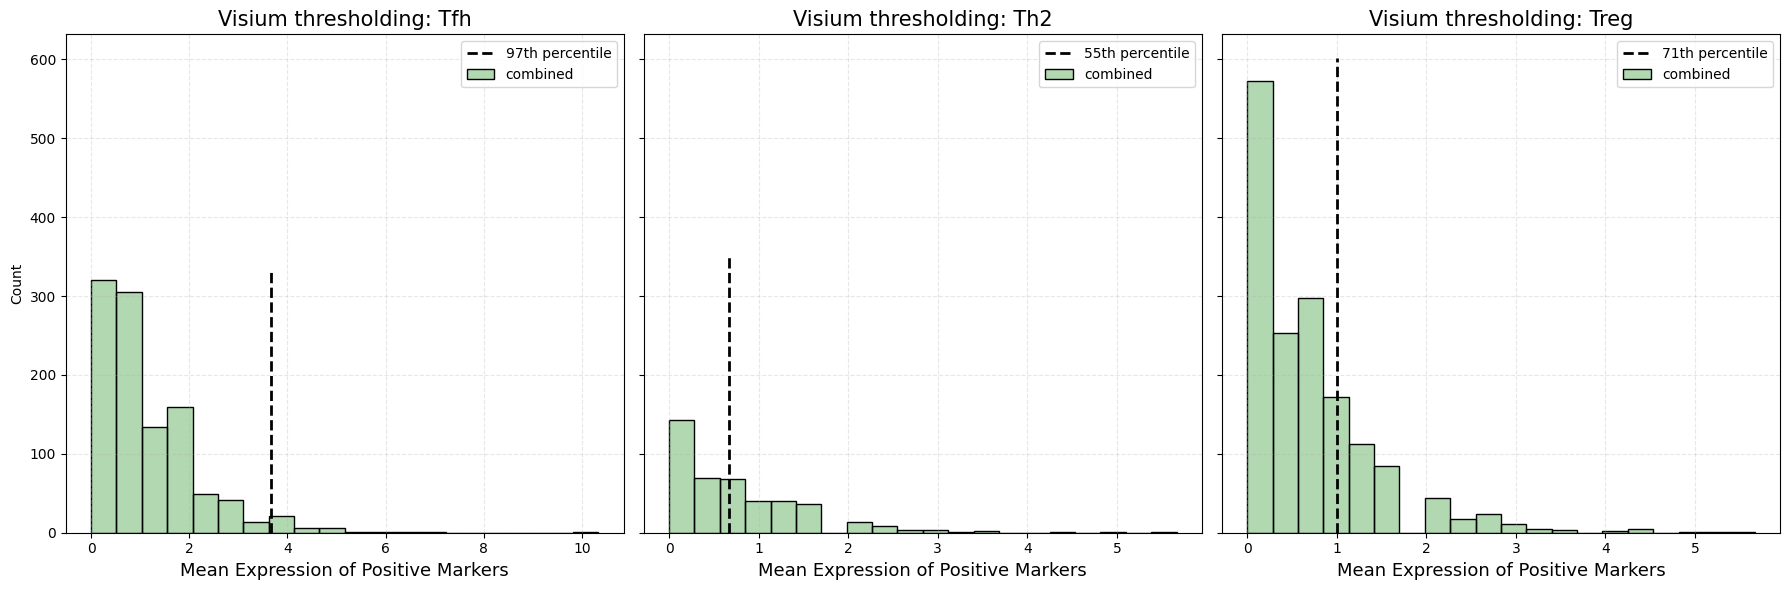

In [158]:
gex_df = visium[:, genes].to_df()
pos_score = gex_df.mean(axis=1)
cell_types = ['Tfh', 'Th2', 'Treg']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, cell_type in enumerate(cell_types):
    ax = axes[i]
    idx = visium.obs['cell_type'] == cell_type
    pos_score_ct = pos_score[idx]
    cutoff = np.percentile(pos_score_ct, percentile_dict[cell_type] * 100)

    sns.histplot(
        pos_score_ct, color='green', alpha=0.3, edgecolor='k', label='combined', bins=20, stat='count', ax=ax
    )
    ax.vlines(cutoff, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='black', linestyle='--', linewidth=2, label=f'{int(percentile_dict[cell_type]*100)}th percentile')
    ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
    ax.set_title(f"Visium thresholding: {cell_type}", fontsize=15)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

In [159]:
transferred = []

for cell_type in cell_types:
    idx = visium.obs['cell_type'] == cell_type
    pos_score_ct = pos_score[idx]
    cutoff = np.percentile(pos_score_ct, percentile_dict[cell_type] * 100)
    transferred.extend(pos_score_ct[pos_score_ct > cutoff].index.values)

np.savetxt('degs_lymph1_transferred.txt', transferred, fmt='%s')
len(transferred), visium[visium.obs.index.isin(transferred)].obs.cell_type.value_counts()

(488,
 cell_type
 Treg    312
 Th2     153
 Tfh      23
 Name: count, dtype: int64)

In [160]:
visium[visium.obs.index.isin(transferred)].obs.cell_type.value_counts() / visium.obs.cell_type.value_counts()

cell_type
Tfh     0.021698
Th2     0.353349
Treg    0.194151
Name: count, dtype: float64

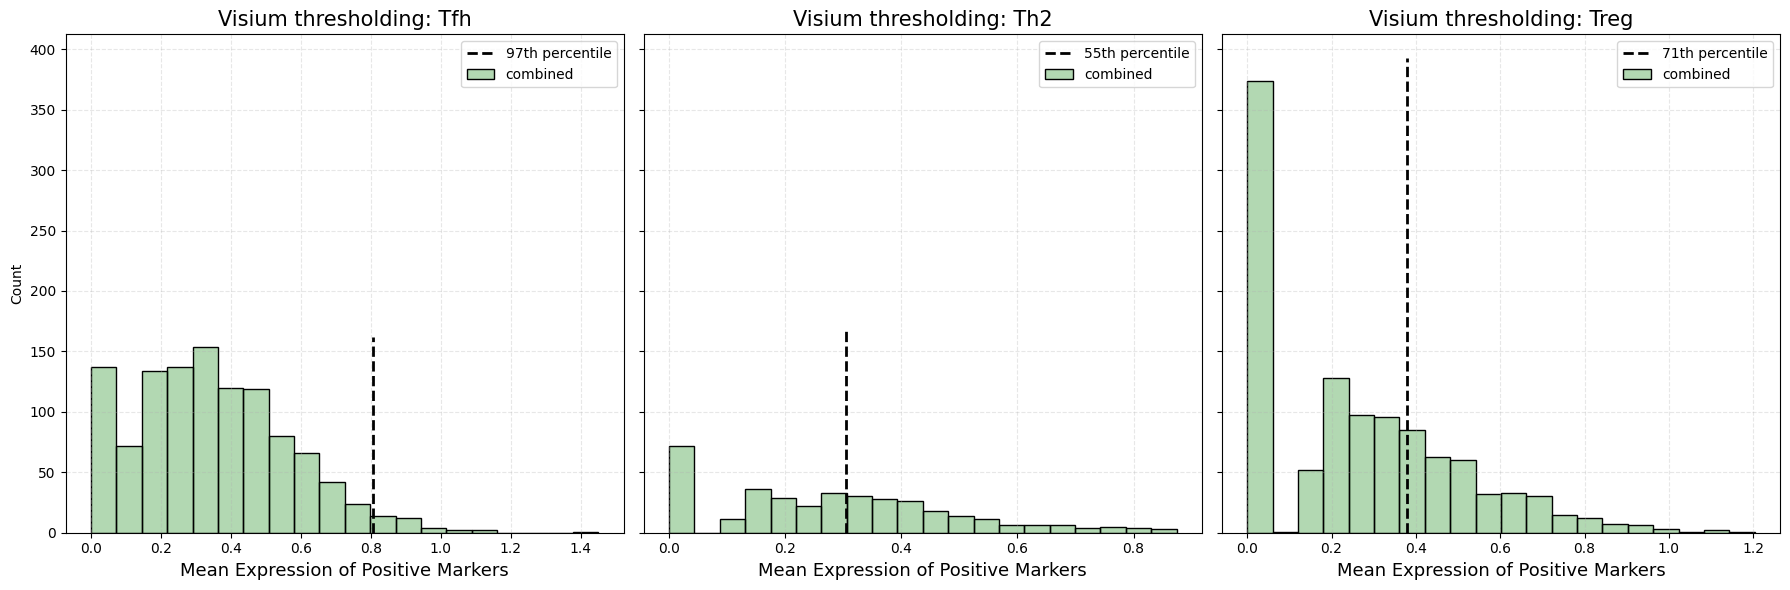

In [161]:
visium = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')
visium = visium[visium.obs.cell_type.isin(['Tfh', 'Th2', 'Treg'])]
gex_df = visium[:, genes].to_df()
pos_score = gex_df.mean(axis=1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, cell_type in enumerate(cell_types):
    ax = axes[i]
    idx = visium.obs['cell_type'] == cell_type
    pos_score_ct = pos_score[idx]
    cutoff = np.percentile(pos_score_ct, percentile_dict[cell_type] * 100)

    sns.histplot(
        pos_score_ct, color='green', alpha=0.3, edgecolor='k', label='combined', bins=20, stat='count', ax=ax
    )
    ax.vlines(cutoff, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='black', linestyle='--', linewidth=2, label=f'{int(percentile_dict[cell_type]*100)}th percentile')
    ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
    ax.set_title(f"Visium thresholding: {cell_type}", fontsize=15)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

In [162]:
transferred = []

for cell_type in cell_types:
    idx = visium.obs['cell_type'] == cell_type
    pos_score_ct = pos_score[idx]
    cutoff = np.percentile(pos_score_ct, percentile_dict[cell_type] * 100)
    transferred.extend(pos_score_ct[pos_score_ct > cutoff].index.values)

np.savetxt('degs_lymphKO2_transferred.txt', transferred, fmt='%s')
len(transferred), visium[visium.obs.index.isin(transferred)].obs.cell_type.value_counts()

(517,
 cell_type
 Treg    319
 Th2     164
 Tfh      34
 Name: count, dtype: int64)

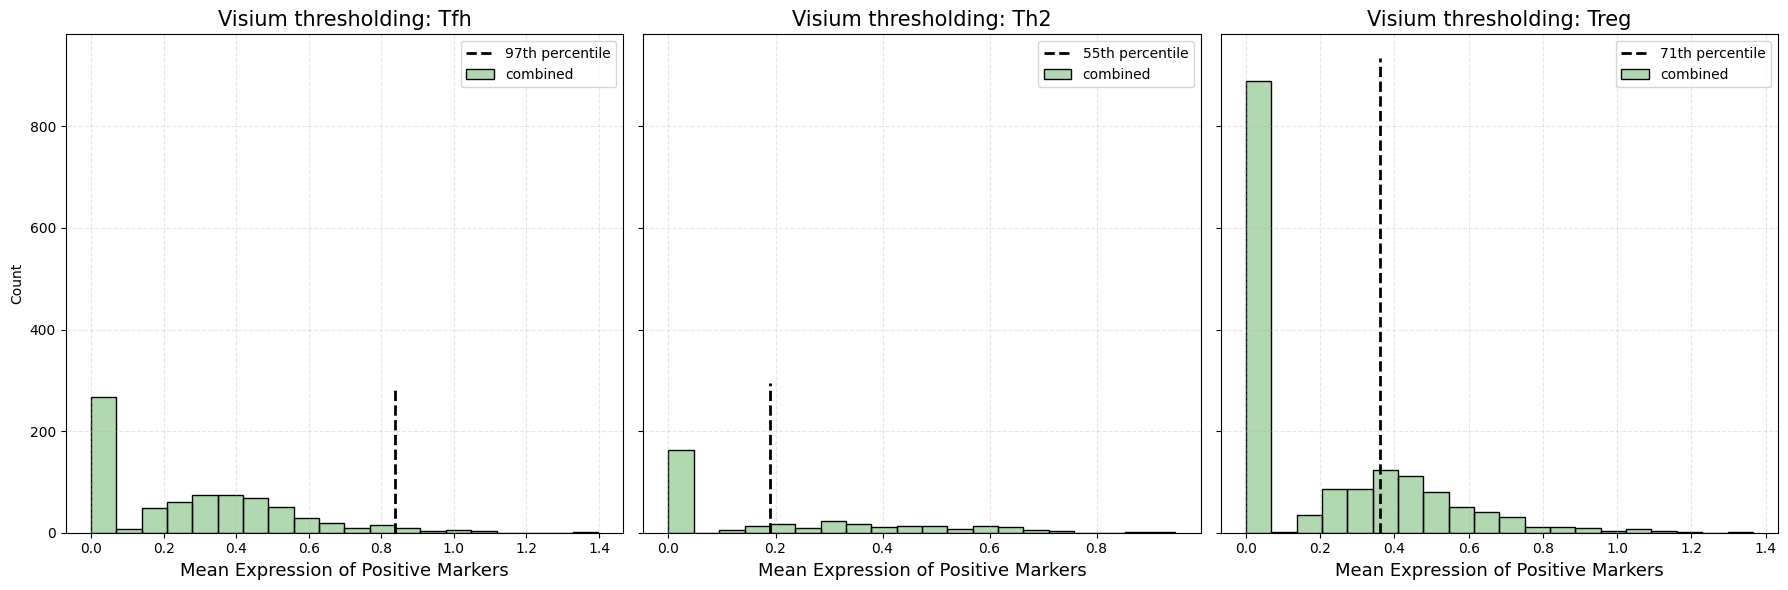

In [163]:
visium = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
visium = visium[visium.obs.cell_type.isin(['Tfh', 'Th2', 'Treg'])]
gex_df = visium[:, genes].to_df()
pos_score = gex_df.mean(axis=1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, cell_type in enumerate(cell_types):
    ax = axes[i]
    idx = visium.obs['cell_type'] == cell_type
    pos_score_ct = pos_score[idx]
    cutoff = np.percentile(pos_score_ct, percentile_dict[cell_type] * 100)

    sns.histplot(
        pos_score_ct, color='green', alpha=0.3, edgecolor='k', label='combined', bins=20, stat='count', ax=ax
    )
    ax.vlines(cutoff, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='black', linestyle='--', linewidth=2, label=f'{int(percentile_dict[cell_type]*100)}th percentile')
    ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
    ax.set_title(f"Visium thresholding: {cell_type}", fontsize=15)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

In [164]:
transferred = []

for cell_type in cell_types:
    idx = visium.obs['cell_type'] == cell_type
    pos_score_ct = pos_score[idx]
    cutoff = np.percentile(pos_score_ct, percentile_dict[cell_type] * 100)
    transferred.extend(pos_score_ct[pos_score_ct > cutoff].index.values)

np.savetxt('degs_lymphKO4_transferred.txt', transferred, fmt='%s')
len(transferred), visium[visium.obs.index.isin(transferred)].obs.cell_type.value_counts()

(632,
 cell_type
 Treg    460
 Th2     149
 Tfh      23
 Name: count, dtype: int64)

In [165]:
visium[visium.obs.index.isin(transferred)].obs.cell_type.value_counts()

cell_type
Treg    460
Th2     149
Tfh      23
Name: count, dtype: int64

: 

### Unused SLIDE signature version

In [70]:
from glob import glob 
best_model = 'slide_runs/scrna_transferred_matched/0.1_0.5_out'
# gene_markers = glob(f'{best_model}/feature_list*csv')
gene_markers = glob(f'{best_model}/feature_list_Z163.csv') # marginal only
genes = pd.concat([pd.read_csv(f, index_col=0, sep='\t') for f in gene_markers], axis=0)
genes = genes[genes.loading.abs() > 0.05]

genes = set(genes.index)
genes = list(genes)
len(genes)

54

In [71]:
genes

['Ttf2',
 'Dennd1a',
 'Gnb4',
 'Dap',
 'Dennd2d',
 'Snapc3',
 'Ccdc58',
 'Klhl6',
 'Mastl',
 'Mrgbp',
 'Spata13',
 'Triap1',
 'Mapk3',
 'Pros1',
 'Ipcef1',
 'Chd7',
 'Trbc1',
 'Tapbpl',
 'Tnfrsf8',
 'Ntrk3',
 'Psap',
 'Zfp275',
 'Fcho2',
 'Tdg',
 'Cd8b1',
 'Arrb2',
 'Nfe2l2',
 'St8sia1',
 'Trac',
 'Alad',
 'Svil',
 'Prkcq',
 'Ankra2',
 'Nav2',
 'Fam189b',
 'Cep83',
 'Nfkbiz',
 'Cd247',
 'Il4',
 'St3gal4',
 'Kif21b',
 'Kbtbd3',
 'Caml',
 'Erg28',
 'Sh3bp1',
 'Podnl1',
 'Rap2b',
 'Trbv2',
 'Stk39',
 'Taf7',
 'Cd4',
 'Lamtor4',
 'Rinl',
 'Mbd4']

In [72]:
pos_genes = scrna_degs[(scrna_degs['logfoldchanges'] > 0) & (scrna_degs['names'].isin(genes))]['names'].values
neg_genes = scrna_degs[(scrna_degs['logfoldchanges'] < 0) & (scrna_degs['names'].isin(genes))]['names'].values

In [73]:
pos_genes, neg_genes

(array(['Trbc1', 'Trac', 'Trbv2', 'Il4', 'Cd8b1', 'Cd247', 'Prkcq', 'Cd4',
        'Tdg', 'St8sia1', 'Psap', 'Mapk3', 'Lamtor4', 'Dennd2d', 'Mastl',
        'Svil', 'Mbd4', 'Rinl', 'Nav2', 'Dennd1a', 'Arrb2', 'Podnl1',
        'Dap', 'Sh3bp1', 'Fam189b', 'Fcho2', 'Caml', 'Triap1', 'Rap2b',
        'Tnfrsf8', 'Snapc3'], dtype=object),
 array(['Gnb4', 'Ttf2', 'Nfkbiz', 'Cep83', 'Spata13', 'Kbtbd3', 'Ccdc58',
        'Taf7', 'Kif21b', 'Ipcef1', 'Mrgbp', 'Stk39', 'Pros1', 'Ankra2',
        'Nfe2l2', 'St3gal4', 'Tapbpl', 'Alad', 'Ntrk3', 'Zfp275', 'Chd7',
        'Klhl6', 'Erg28'], dtype=object))

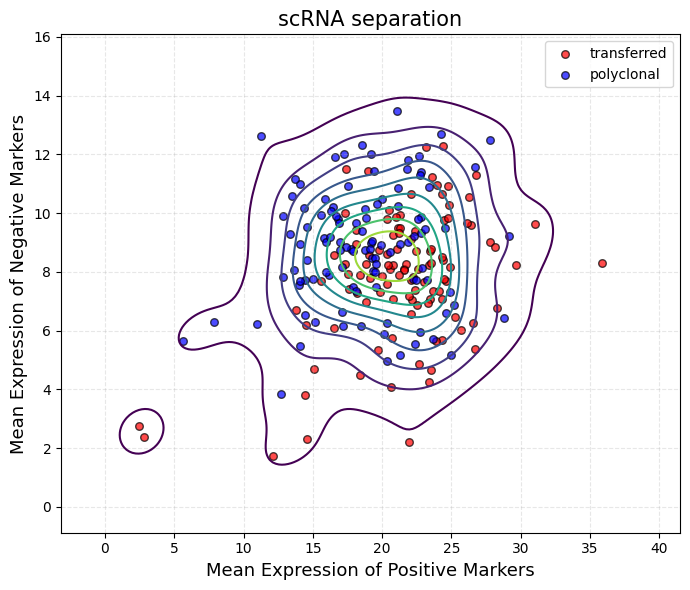

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns 

pos_score = scrna.to_df()[pos_genes].sum(axis=1)
neg_score = scrna.to_df()[neg_genes].sum(axis=1)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(
    pos_score[scrna.obs['transferred'] == '1'], neg_score[scrna.obs['transferred'] == '1'], 
    c='red', alpha=0.7, edgecolor='k', s=30, label='transferred')
ax.scatter(
    pos_score[scrna.obs['transferred'] == '0'], neg_score[scrna.obs['transferred'] == '0'], 
    c='blue', alpha=0.7, edgecolor='k', s=30, label='polyclonal')

sns.kdeplot(x = pos_score, y = neg_score, cmap = 'viridis')

ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
ax.set_ylabel("Mean Expression of Negative Markers", fontsize=13)
ax.set_title("scRNA separation", fontsize=15)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [75]:
slideseq.obs['transferred'] = slideseq.obs['transferred'].astype(int).astype('category')

/tmp/ipykernel_11401/910723195.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  slideseq.obs['transferred'] = slideseq.obs['transferred'].astype(int).astype('category')


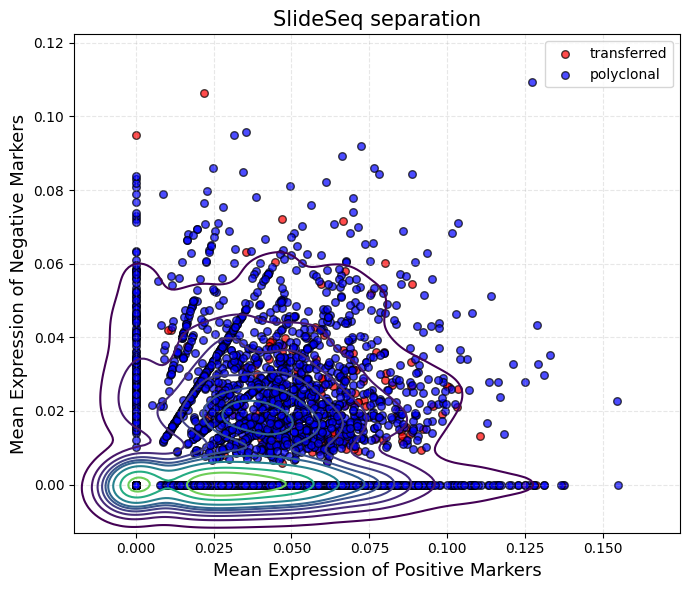

In [78]:
pos_score = slideseq.to_df()[pos_genes].mean(axis=1)
neg_score = slideseq.to_df()[neg_genes].mean(axis=1)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(
    pos_score[slideseq.obs['transferred'] == 1], neg_score[slideseq.obs['transferred'] == 1], 
    c='red', alpha=0.7, edgecolor='k', s=30, label='transferred')
ax.scatter(
    pos_score[slideseq.obs['transferred'] == 0], neg_score[slideseq.obs['transferred'] == 0], 
    c='blue', alpha=0.7, edgecolor='k', s=30, label='polyclonal')
sns.kdeplot(x = pos_score, y = neg_score, cmap = 'viridis')

ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
ax.set_ylabel("Mean Expression of Negative Markers", fontsize=13)
ax.set_title("SlideSeq separation", fontsize=15)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [79]:
visium = visium[visium.obs.cell_type.isin(['Tfh', 'Treg', 'Th2'])]
visium.obs.cell_type.value_counts()

cell_type
Treg    1586
Tfh      747
Th2      332
Name: count, dtype: int64

/tmp/ipykernel_11401/1068915149.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


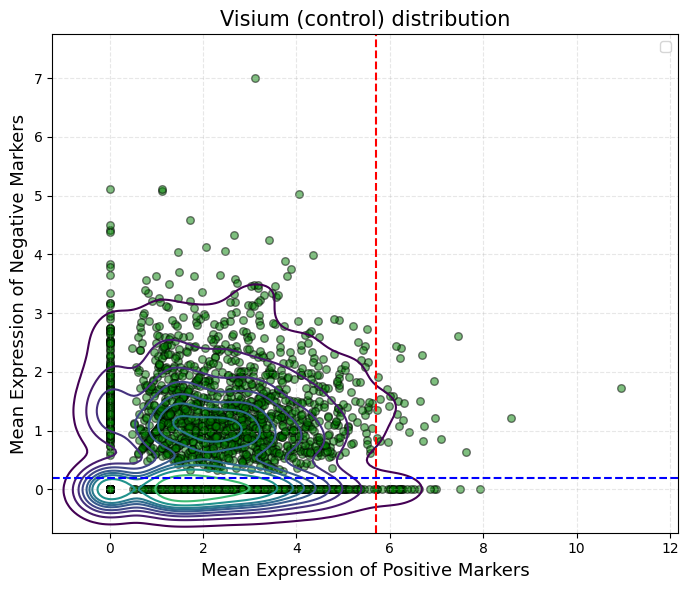

In [80]:
pos_score = visium.to_df(layer='normalized_count')[pos_genes].sum(axis=1)
neg_score = visium.to_df(layer='normalized_count')[neg_genes].sum(axis=1)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(pos_score, neg_score, c='green', alpha=0.5, edgecolor='k', s=30)
sns.kdeplot(x = pos_score, y = neg_score, cmap = 'viridis')

pos_thresh = 5.7
neg_thresh = 0.2

ax.vlines(pos_thresh, ax.get_ylim()[0], ax.get_ylim()[1], color='red', linestyle='--')
ax.hlines(neg_thresh, ax.get_xlim()[0], ax.get_xlim()[1], color='blue', linestyle='--')

ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
ax.set_ylabel("Mean Expression of Negative Markers", fontsize=13)
ax.set_title("Visium (control) distribution", fontsize=15)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [81]:
df = pd.DataFrame({'pos_score': pos_score, 'neg_score': neg_score})
df = df[(df.pos_score > pos_thresh) | ((df.neg_score < neg_thresh) & (df.pos_score > 0))]
df.shape

(986, 2)

In [101]:
visium.shape

(3100, 2062)

In [102]:
669/3100

0.21580645161290324

In [103]:
th2_poly = set(visium[visium.obs.cell_type.isin(['Th2'])].obs.index) & set(df.index)
len(th2_poly)

72

: 

In [54]:
np.savetxt('visium_polyclonal.txt', df.index.values, fmt='%s')

In [55]:
visium = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
visium = visium[visium.obs.cell_type.isin(['Tfh', 'Treg', 'Th2'])]
visium

View of AnnData object with n_obs × n_vars = 2665 × 2116
    obs: 'cell_type', 'secondary_annot', 'cell_type_int'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'

/tmp/ipykernel_58830/496704188.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


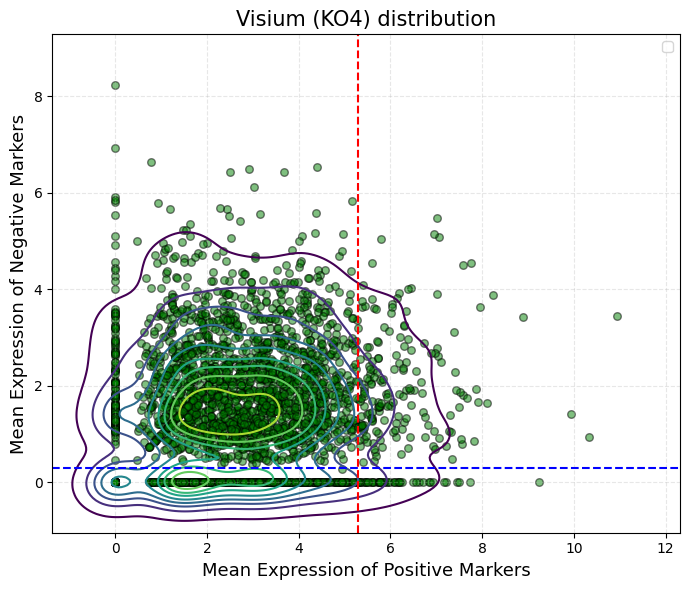

In [70]:
pos_score = visium.to_df(layer='normalized_count')[pos_genes].sum(axis=1)
neg_score = visium.to_df(layer='normalized_count')[neg_genes].sum(axis=1)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(pos_score, neg_score, c='green', alpha=0.5, edgecolor='k', s=30)
sns.kdeplot(x = pos_score, y = neg_score, cmap = 'viridis')

pos_thresh = 5.3
neg_thresh = 0.3

ax.vlines(pos_thresh, ax.get_ylim()[0], ax.get_ylim()[1], color='red', linestyle='--')
ax.hlines(neg_thresh, ax.get_xlim()[0], ax.get_xlim()[1], color='blue', linestyle='--')

ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
ax.set_ylabel("Mean Expression of Negative Markers", fontsize=13)
ax.set_title("Visium (KO4) distribution", fontsize=15)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [71]:
df = pd.DataFrame({'pos_score': pos_score, 'neg_score': neg_score})
df = df[(df.pos_score > pos_thresh) | ((df.neg_score < neg_thresh) & (df.pos_score > 0.1))]
df

,pos_score,neg_score
object_id,,
106273,6.037002,3.687989
104715,1.584917,0.000000
66595,3.320535,0.000000
70228,7.007054,2.776823
97689,1.417966,0.000000
...,...,...
42192,3.343915,0.000000
33070,3.441883,0.000000
76543,4.935421,0.000000


In [72]:
667 / 2665

0.25028142589118196

In [73]:
# ko_cells = visium[df.index, ['Ccr4']].to_df(layer='raw_count') 
# ko_cells = ko_cells[ko_cells['Ccr4'] <= 0]

ko_cells = df
len(ko_cells)


667

In [74]:
np.savetxt('lymphKO4_transferred.txt', ko_cells.index.values, fmt='%s')

In [75]:
visium = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')
visium = visium[visium.obs.cell_type.isin(['Tfh', 'Treg', 'Th2'])]
visium

View of AnnData object with n_obs × n_vars = 2582 × 2116
    obs: 'cell_type', 'secondary_annot'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca', 'spatial', 'spatial_unscaled'
    layers: 'corrected_count', 'normalized_count', 'raw_count'

/tmp/ipykernel_58830/3126445638.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


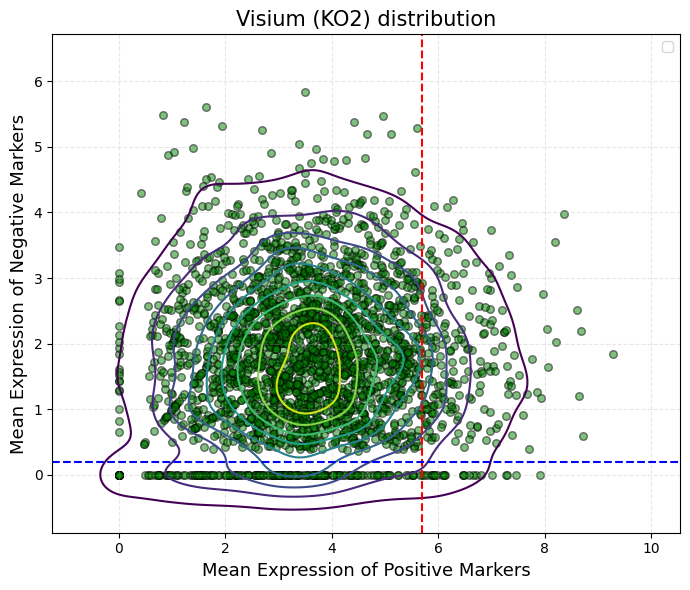

In [80]:
pos_score = visium.to_df(layer='normalized_count')[pos_genes].sum(axis=1)
neg_score = visium.to_df(layer='normalized_count')[neg_genes].sum(axis=1)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(pos_score, neg_score, c='green', alpha=0.5, edgecolor='k', s=30)
sns.kdeplot(x = pos_score, y = neg_score, cmap = 'viridis')

pos_thresh = 5.7
neg_thresh = 0.2

ax.vlines(pos_thresh, ax.get_ylim()[0], ax.get_ylim()[1], color='red', linestyle='--')
ax.hlines(neg_thresh, ax.get_xlim()[0], ax.get_xlim()[1], color='blue', linestyle='--')

ax.set_xlabel("Mean Expression of Positive Markers", fontsize=13)
ax.set_ylabel("Mean Expression of Negative Markers", fontsize=13)
ax.set_title("Visium (KO2) distribution", fontsize=15)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [81]:
df = pd.DataFrame({'pos_score': pos_score, 'neg_score': neg_score})
df = df[(df.pos_score > pos_thresh) | ((df.neg_score < neg_thresh) & (df.pos_score > 0.1))]
df

,pos_score,neg_score
object_id,,
295733,6.357580,0.843779
306552,6.966706,2.526889
302565,4.743038,0.000000
354959,2.601267,0.000000
370679,6.499393,3.227115
...,...,...
320247,5.728801,2.080201
359176,6.281114,1.590401
317547,6.970929,0.672178


In [82]:
417 / 2582

0.16150271107668474

In [83]:
# ko_cells = visium[df.index, ['Ccr4']].to_df(layer='raw_count') 
# ko_cells = ko_cells[ko_cells['Ccr4'] <= 0]

ko_cells = df
len(ko_cells)

417

In [84]:
np.savetxt('lymphKO2_transferred.txt', ko_cells.index.values, fmt='%s')